# Import Libraries

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the Dataset

In [2]:
df = pd.read_csv("../data/eda_data.csv")

In [3]:
# Make a copy of the dataframe
df_copy = df.copy()

# Convert Date Time column to datetime
df_copy.index = pd.to_datetime(df_copy.pop("Date Time"))

In [4]:
df_stats = df_copy.describe().transpose()

# Data Preprocessing

## Data Cleaning

In [5]:
# Resample the data
df_copy = df_copy.resample("H").mean()

In [6]:
# Remove outlier from wind speed and max wind speed
mean_wind_speed = df_stats.loc["Wind speed", "50%"]

# Replace the outlier with the mean wind speed
df_copy.loc[df_copy["Wind speed"] < -100, "Wind speed"] = mean_wind_speed
df_copy.loc[df_copy["Max wind speed"] < -100, "Max wind speed"] = mean_wind_speed

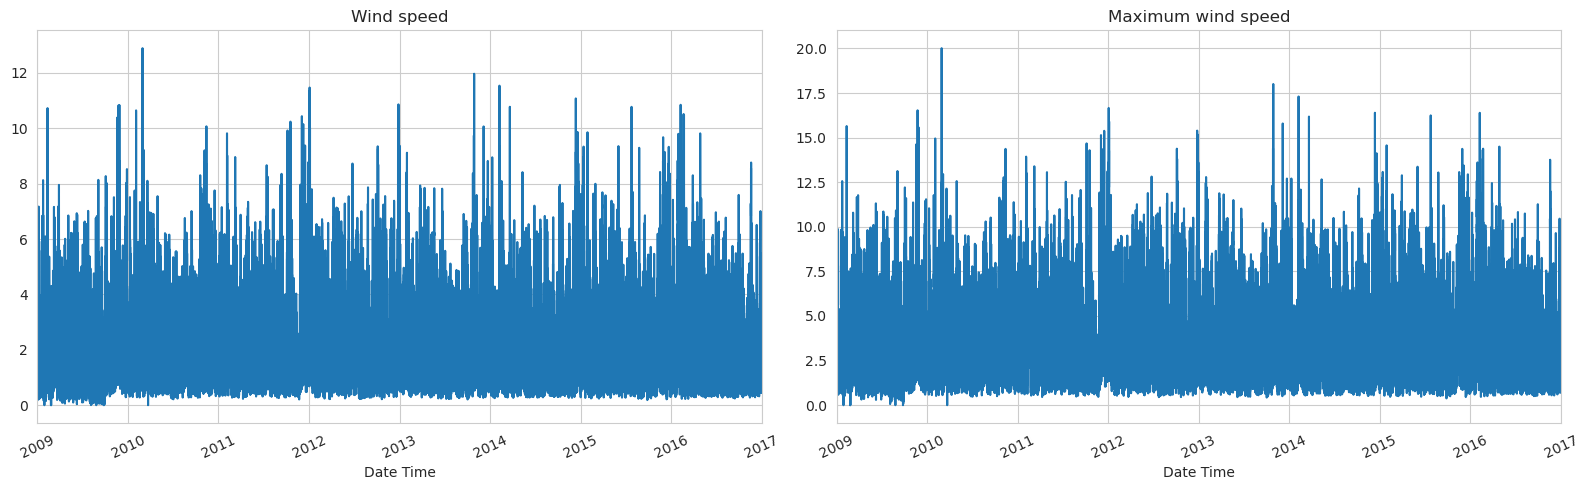

In [7]:
# Visualize the wind speed again
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
df_copy["Wind speed"].plot(title="Wind speed", rot=25, ax=axes[0])
df_copy["Max wind speed"].plot(title="Maximum wind speed", rot=25, ax=axes[1])
plt.tight_layout()

In [8]:
# Remove Temp (Kelvin) column
df_copy.drop("Temp (Kelvin)", axis=1, inplace=True)

In [9]:
# Remove Max wind speed column
df_copy.drop("Max wind speed", axis=1, inplace=True)

## Feature Engineering 

### Wind direction and Wind Speed

- Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. 
- Direction shouldn't matter if the wind is not blowing.

We will convert the wind direction and wind speed columns to a wind vector

In [10]:
wv = df_copy.pop("Wind speed")

# Convert to radians.
wd_rad = df_copy.pop("Wind direction (degrees)") * np.pi / 180

# Calculate the wind x and y components.
df_copy["Wx"] = wv * np.cos(wd_rad)
df_copy["Wy"] = wv * np.sin(wd_rad)

In [11]:
df_copy.head()

,Pressure,Temp,Temp (dew point),Relative Humidity,Saturation vapor pressure,Vapor pressure,Vapor pressure deficit,Specific humidity,Water vapor concentration,Airtight,Wx,Wy
Date Time,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,-0.517571,0.050201
2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,-0.313897,0.041790
2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,-0.237713,-0.071845
2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,-0.162723,0.068793
2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,-0.251383,0.144591


In [12]:
df_corr = df_copy.corr()

In [13]:
df_corr["Temp"].sort_values(ascending=False)

Temp                         1.000000
Saturation vapor pressure    0.951204
Temp (dew point)             0.896856
Vapor pressure               0.869021
Water vapor concentration    0.868516
Specific humidity            0.868097
Vapor pressure deficit       0.762056
Wy                          -0.031684
Pressure                    -0.045224
Wx                          -0.078670
Relative Humidity           -0.572049
Airtight                    -0.963347
Name: Temp, dtype: float64

After converting the wind direction and wind speed columns to a wind vector, The new features correlates more with the temperature.

### Seasonality

As the task is weather forecasting, we will add some datetime features to help our model learn the seasonality and time of day patterns.

We will add the following features:
- Month of the year (to identify seasonal patterns)
- Hour of the day (to identify day/night patterns)

In [14]:
# day and year in seconds
day = 24 * 60 * 60
year = (365.2425) * day

df_copy["Day sin"] = np.sin(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / day))
df_copy["Day cos"] = np.cos(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / day))
df_copy["Year sin"] = np.sin(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / year))
df_copy["Year cos"] = np.cos(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / year))

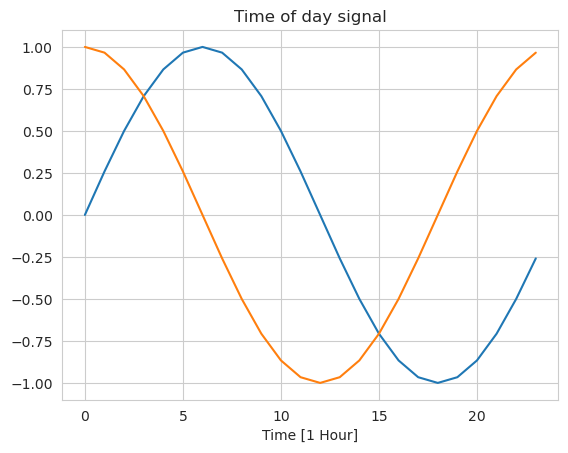

In [15]:
plt.plot(np.array(df_copy.loc["2009-1-1"]["Day sin"]))
plt.plot(np.array(df_copy.loc["2009-1-1"]["Day cos"]))
plt.xlabel("Time [1 Hour]")
plt.title("Time of day signal")
plt.show()

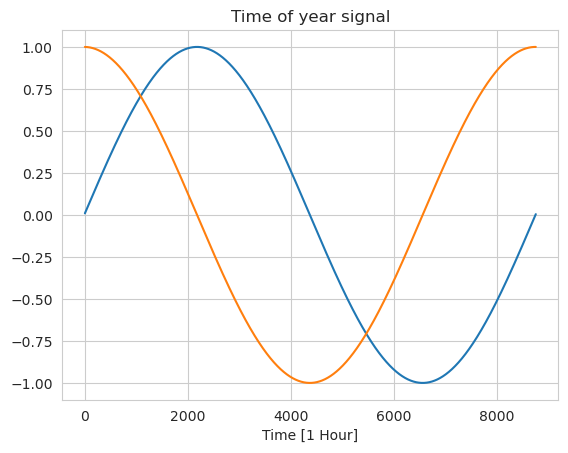

In [16]:
plt.plot(np.array(df_copy.loc["2009"]["Year sin"]))
plt.plot(np.array(df_copy.loc["2009"]["Year cos"]))
plt.xlabel("Time [1 Hour]")
plt.title("Time of year signal")
plt.show()

In [17]:
df_copy.corr()["Temp"].sort_values(ascending=False)

Temp                         1.000000
Saturation vapor pressure    0.951204
Temp (dew point)             0.896856
Vapor pressure               0.869021
Water vapor concentration    0.868516
Specific humidity            0.868097
Vapor pressure deficit       0.762056
Wy                          -0.031684
Pressure                    -0.045224
Wx                          -0.078670
Day cos                     -0.179983
Day sin                     -0.190391
Year sin                    -0.233681
Relative Humidity           -0.572049
Year cos                    -0.764070
Airtight                    -0.963347
Name: Temp, dtype: float64

## Splitting the data

In [18]:
train_size = int(0.7 * len(df_copy))
val_size = int(0.15 * len(df_copy))
test_size = int(0.15 * len(df_copy))

# Split the data into train 70%, validation 15%, and test 15%
train_df = df_copy.iloc[:train_size]
val_df = df_copy.iloc[train_size : train_size + val_size]
test_df = df_copy.iloc[train_size + val_size :]

In [19]:
train_df.head()

,Pressure,Temp,Temp (dew point),Relative Humidity,Saturation vapor pressure,Vapor pressure,Vapor pressure deficit,Specific humidity,Water vapor concentration,Airtight,Wx,Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,-0.517571,0.050201,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,-0.313897,0.041790,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,-0.237713,-0.071845,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,-0.162723,0.068793,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,-0.251383,0.144591,8.660254e-01,0.500000,0.012199,0.999926


## Normalize the data

In [20]:
sc = StandardScaler()
train_scaled = sc.fit_transform(train_df)

In [21]:
# Use the same scaler to transform the validation and test sets
val_scaled = sc.transform(val_df)
test_scaled = sc.transform(test_df)

In [22]:
# Update the dataframes with the scaled values
train_df = pd.DataFrame(train_scaled, columns=df_copy.columns, index=train_df.index)
val_df = pd.DataFrame(val_scaled, columns=df_copy.columns, index=val_df.index)
test_df = pd.DataFrame(test_scaled, columns=df_copy.columns, index=test_df.index)

/tmp/ipykernel_119696/3054808872.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_copy.keys(), rotation=90)


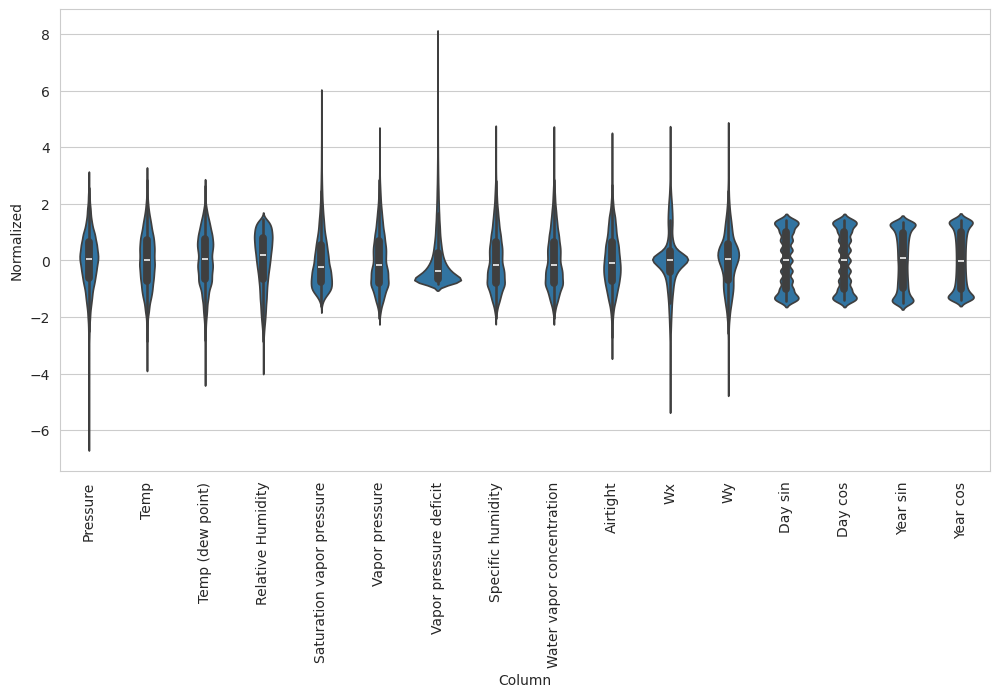

In [23]:
df_std = train_df.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df_copy.keys(), rotation=90)
plt.show()

# Save the datasets

In [24]:
train_df.to_csv("../data/pre_train.csv", index=True)
val_df.to_csv("../data/pre_val.csv", index=True)
test_df.to_csv("../data/pre_test.csv", index=True)